In [16]:
import os
import subprocess
import sys

print("JAVA_HOME:", os.environ.get("JAVA_HOME"))
print("SPARK_HOME:", os.environ.get("SPARK_HOME"))
print("Python version:", sys.version)

try:
    result = subprocess.run(["java", "-version"], capture_output=True, text=True)
    print("java -version output:")
    print(result.stderr)
except Exception as e:
    print("Error menjalankan java:", e)

JAVA_HOME: /home/hani/anaconda3/envs/BigData024
SPARK_HOME: /home/hani/Downloads/spark-3.5.6-bin-hadoop3
Python version: 3.13.7 | packaged by Anaconda, Inc. | (main, Sep  9 2025, 19:59:03) [GCC 11.2.0]
java -version output:
openjdk version "21.0.6" 2025-01-21
OpenJDK Runtime Environment JBR-21.0.6+9-895.97-nomod (build 21.0.6+9-b895.97)
OpenJDK 64-Bit Server VM JBR-21.0.6+9-895.97-nomod (build 21.0.6+9-b895.97, mixed mode, sharing)



In [1]:
import sys
print(sys.executable)

/home/hani/anaconda3/envs/BigData024/bin/python


In [2]:
import findspark
findspark.init()
print('SPARK_HOME:', findspark.find())

SPARK_HOME: /home/hani/Downloads/spark-3.5.6-bin-hadoop3


In [3]:
# Membuat SparkSession dan Load Dataset

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('TikTokReviewAnalysis').getOrCreate()

df = spark.read.csv('/home/hani/Downloads/TIKTOKNONLITE_REVIEWS.csv', header=True, inferSchema=True)

print('SparkSession berhasil dibuat dan siap digunakan!')

25/11/26 07:50:55 WARN Utils: Your hostname, hani-HP-240-G8-Notebook-PC resolves to a loopback address: 127.0.1.1; using 10.125.133.203 instead (on interface wlo1)
25/11/26 07:50:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/26 07:50:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/26 07:51:15 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
[Stage 1:============================================>              (3 + 1) / 4]

SparkSession berhasil dibuat dan siap digunakan!


In [4]:
# Informasi Dataset

print('\033[1mINFORMASI AWAL DATASET\033[0m')
df.printSchema()
print('Jumlah baris:', df.count())
print('Jumlah kolom:', len(df.columns))

INFORMASI AWAL DATASET
root
 |-- review_id: string (nullable = true)
 |-- pseudo_author_id: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- review_rating: string (nullable = true)
 |-- review_likes: string (nullable = true)
 |-- author_app_version: string (nullable = true)
 |-- review_timestamp: string (nullable = true)



[Stage 2:>                                                          (0 + 4) / 4]

Jumlah baris: 1633322
Jumlah kolom: 8


In [5]:
# Menampilkan 5 data teratas

df.show(5)

+--------------------+--------------------+-----------+--------------+-------------+------------+------------------+-------------------+
|           review_id|    pseudo_author_id|author_name|   review_text|review_rating|review_likes|author_app_version|   review_timestamp|
+--------------------+--------------------+-----------+--------------+-------------+------------+------------------+-------------------+
|8cf04c82-9db1-40d...|28728360376546148...|Google 用户|Cool video app|            5|          19|             1.0.3|2017-05-18 08:18:19|
|3fcef099-809c-445...|14341588114148482...|Google 用户|          Cool|            5|           5|              NULL|2017-05-21 13:21:47|
|521361eb-bfd6-464...|21683027288194333...|Google 用户|        fany！|            5|           8|              NULL|2017-05-22 03:10:00|
|125e8710-956a-4ed...|24768692603203969...|Google 用户|          COOL|            5|           0|              NULL|2017-05-24 08:19:27|
|569d5d2c-1294-46c...|11917156690044714...|Google 

In [5]:
# Data Preproccessing: Deteksi Missing Values 

from pyspark.sql.functions import col, when, count

# Menghitung jumlah missing values di setiap kolom
print('\033[1mJUMLAH MISSING VALUES DI SETIAP KOLOM:\033[0m')

missing_values = df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df.columns
])

missing_values.show()

JUMLAH MISSING VALUES DI SETIAP KOLOM:


[Stage 5:============================================>              (3 + 1) / 4]

+---------+----------------+-----------+-----------+-------------+------------+------------------+----------------+
|review_id|pseudo_author_id|author_name|review_text|review_rating|review_likes|author_app_version|review_timestamp|
+---------+----------------+-----------+-----------+-------------+------------+------------------+----------------+
|        3|             830|        966|       2223|         3545|        5788|            631478|            6301|
+---------+----------------+-----------+-----------+-------------+------------+------------------+----------------+



In [6]:
# Data Preproccessing: Handling Missing Values 

from pyspark.sql.functions import mean, col
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import to_timestamp

# Ubah string kosong menjadi null (default spark)
df = df.replace('', None)
df = df.replace('NULL', None)

# Konversi tipe data pada kolom tertentu
df = df.withColumn('review_rating', col('review_rating').cast(IntegerType()))
df = df.withColumn('review_likes', col('review_likes').cast(IntegerType()))
df = df.withColumn('review_timestamp', to_timestamp(col('review_timestamp')))

# Handling missing values kolom author_name - string kosong
df = df.fillna({'author_name': 'Anonymous'})

# Handling missing values kolom review_text - string kosong
df = df.fillna({'review_text': ''})

# Handling missing values kolom review_rating - hapus
df = df.dropna(subset=['review_rating'])

# Handling missing values kolom review_likes - isi 0
df = df.fillna({'review_likes': 0})

# Handling missing values kolom author_app_version - string Unknown
df = df.fillna({'author_app_version': 'Unknown'})

# Handling missing values kolom review_timestamp - hapus
df = df.dropna(subset=['review_timestamp'])

# Menghitung jumlah missing values di setiap kolom setelah penanganan
print('\033[1mJUMLAH MISSING VALUES DI SETIAP KOLOM (AFTER HANDLING):\033[0m')

missing_values = df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df.columns
])

missing_values.show()

JUMLAH MISSING VALUES DI SETIAP KOLOM (AFTER HANDLING):


[Stage 8:==============>                                            (1 + 3) / 4]

+---------+----------------+-----------+-----------+-------------+------------+------------------+----------------+
|review_id|pseudo_author_id|author_name|review_text|review_rating|review_likes|author_app_version|review_timestamp|
+---------+----------------+-----------+-----------+-------------+------------+------------------+----------------+
|        0|               1|          0|          0|            0|           0|                 0|               0|
+---------+----------------+-----------+-----------+-------------+------------+------------------+----------------+



In [7]:
# Data Preprocessing: Deteksi dan Penanganan Inkonsistensi (invalid rating)

# Cari rating yang invalid (review_rating harus bernilai 1-5)
valid_rating = [1, 2, 3, 4, 5]

invalid = df.filter(~col('review_rating').isin(valid_rating))
invalid_count = invalid.count()

# hitung persentase rating invalid
total_rows = df.count()
percentage = (invalid_count / total_rows) * 100

print(f'\033[1mInvalid rating: {invalid_count} baris ({percentage:.2f}%)\033[0m', )
invalid.show()

# Handling invalid rating
if percentage < 5:
    print('Invalid rating < 5%, baris akan dihapus!')
    df = df.filter(col('review_rating').isin(valid_rating))
else:
    print('Invalid rating >= 5%, baris akan diimputasi median!')
    median_rating = df.approxQuantile('review_rating', [0.5], 0.0)[0]
    df = df.withColumn('review_rating',
                       when(col("review_rating").isin(valid_rating), col('review_rating')).otherwise(median_rating))

# Cek ulang apakah masih ada rating invalid atau tidak
remaining_invalid = df.filter(~col('review_rating').isin(valid_rating)).count()

print("\n\033[1mJumlah baris dengan rating invalid setelah penanganan:\033[0m", remaining_invalid)

Invalid rating: 4 baris (0.00%)


+--------------------+--------------------+-------------+--------------------+-------------+------------+------------------+-------------------+
|           review_id|    pseudo_author_id|  author_name|         review_text|review_rating|review_likes|author_app_version|   review_timestamp|
+--------------------+--------------------+-------------+--------------------+-------------+------------+------------------+-------------------+
|2c87c3d4-be07-432...|20178185612806545...|A Google user|           Love's it|            0|           0|             2.0.8|2018-05-03 12:37:47|
|dcd0f05a-be87-433...|19637242327153950...|A Google user|Like it very much 😘|            0|           1|             2.0.9|2018-05-11 05:33:59|
|d13a0f35-08be-483...|44704881839743610...|A Google user|Good social chat ...|            0|           6|             2.6.2|2018-07-15 13:13:28|
|a601780a-e5e0-481...|16709131592893044...|A Google user|      Love Tik Tok❤️|            0|          11|             2.6.9|2018-07

In [8]:
# Data Preprocessing: Deteksi dan Penanganan Duplikasi Data

# Cek duplikasi data berdasarkan kolom review_id
duplicate = (df.groupBy('review_id').count().filter(col('count') > 1))

print("\033[1mJumlah duplikasi yang ditemukan:\033[0m", duplicate.count())

# Tidak ada penanganan karena tidak terdeteksi duplikasi di dataset

[Stage 23:=============================>                            (2 + 2) / 4]

Jumlah duplikasi yang ditemukan: 0


In [10]:
# Informasi dataset setelah data preprocessing

print('\033[1mINFORMASI DATASET SETELAH DATA PREPROCESSING\033[0m')
df.printSchema()
print('Jumlah baris:', df.count())
print('Jumlah kolom:', len(df.columns))

INFORMASI DATASET SETELAH DATA PREPROCESSING
root
 |-- review_id: string (nullable = true)
 |-- pseudo_author_id: string (nullable = true)
 |-- author_name: string (nullable = false)
 |-- review_text: string (nullable = false)
 |-- review_rating: integer (nullable = true)
 |-- review_likes: integer (nullable = false)
 |-- author_app_version: string (nullable = false)
 |-- review_timestamp: timestamp (nullable = true)



[Stage 28:=============================>                            (2 + 2) / 4]

Jumlah baris: 1624945
Jumlah kolom: 8


In [11]:
# Statistik Deskriptif Kolom review_likes

print('\033[1mSTATISTIK DESKRIPTIF KOLOM review_likes\033[0m')
df.select('review_likes').describe().show()

STATISTIK DESKRIPTIF KOLOM review_likes


[Stage 31:>                                                         (0 + 4) / 4]

+-------+-----------------+
|summary|     review_likes|
+-------+-----------------+
|  count|          1624945|
|   mean| 2.03455993895178|
| stddev|101.4623281754112|
|    min|                0|
|    max|            50320|
+-------+-----------------+



In [9]:
# Deteksi Outlier Kolom review_likes dengan Metode IQR
# untuk menentukan batas upper dan lower yang dianggap outlier

from pyspark.sql.functions import col

# Menghitung Q1 dan Q3 menggunakan approxQuantile
quantiles = df.approxQuantile("review_likes", [0.25, 0.75], 0.0)  # toleransi error: 0.0
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('Q1  :', Q1)
print('Q3  :', Q3)
print('IQR :', IQR)
print('Lower bound :', lower_bound)
print('Upper bound :', upper_bound)


# Hitung jumlah outlier
outliers = df.filter((col('review_likes') < lower_bound) | (col('review_likes') > upper_bound))
print('\033[1mJumlah outlier yang terdeteksi:\033[0m', outliers.count())

Q1  : 0.0
Q3  : 0.0
IQR : 0.0
Lower bound : 0.0
Upper bound : 0.0


[Stage 28:==============>                                           (1 + 3) / 4]

Jumlah outlier yang terdeteksi: 133249


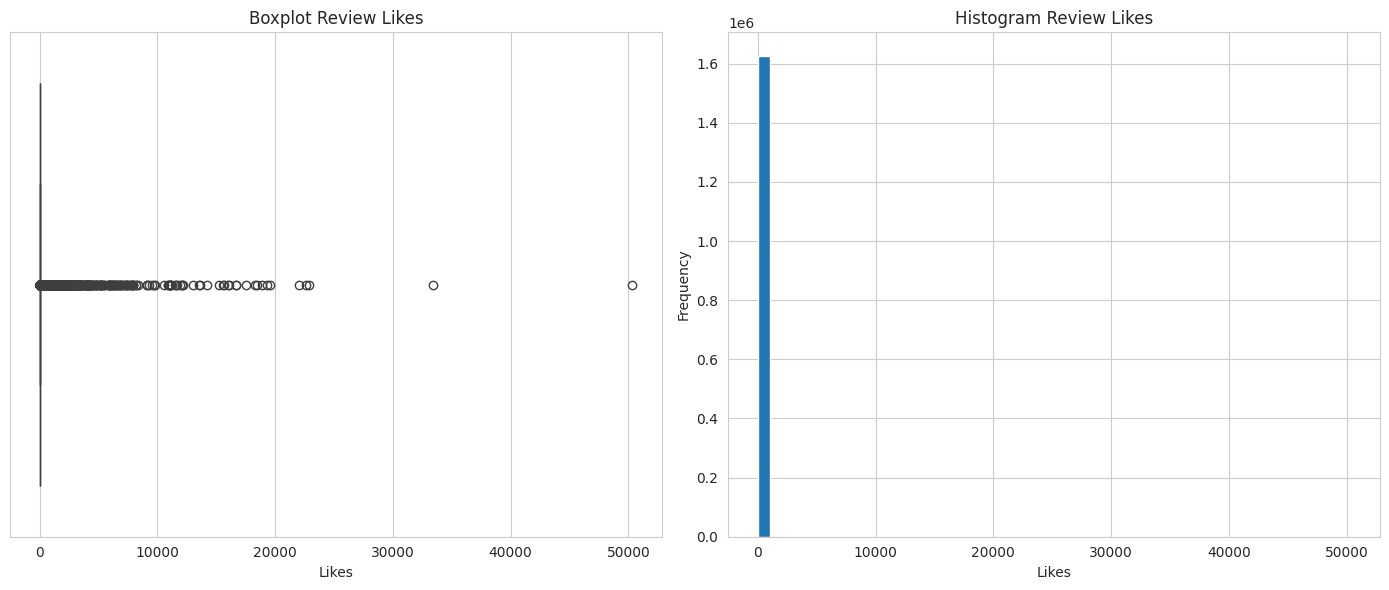

In [13]:
# Visualisasi Deteksi Outlier Kolom review_likes dengan Boxplot dan Histogram

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

revlike_pandas = df.select('review_likes').toPandas() # Convert ke pandas

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot
sns.boxplot(x=revlike_pandas['review_likes'], vert=False, showfliers=True, ax=axes[0])
axes[0].set_title('Boxplot Review Likes')
axes[0].set_xlabel('Likes')

# Histogram
axes[1].hist(revlike_pandas['review_likes'], bins=50)
axes[1].set_title('Histogram Review Likes')
axes[1].set_xlabel('Likes')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
# Handling outlier dengan log transform

from pyspark.sql.functions import log1p

df = df.withColumn('review_likes_log', log1p(col('review_likes')))

print('Outlier berhasil ditangani menggunakan Log Transform!')

Outlier berhasil ditangani menggunakan Log Transform!


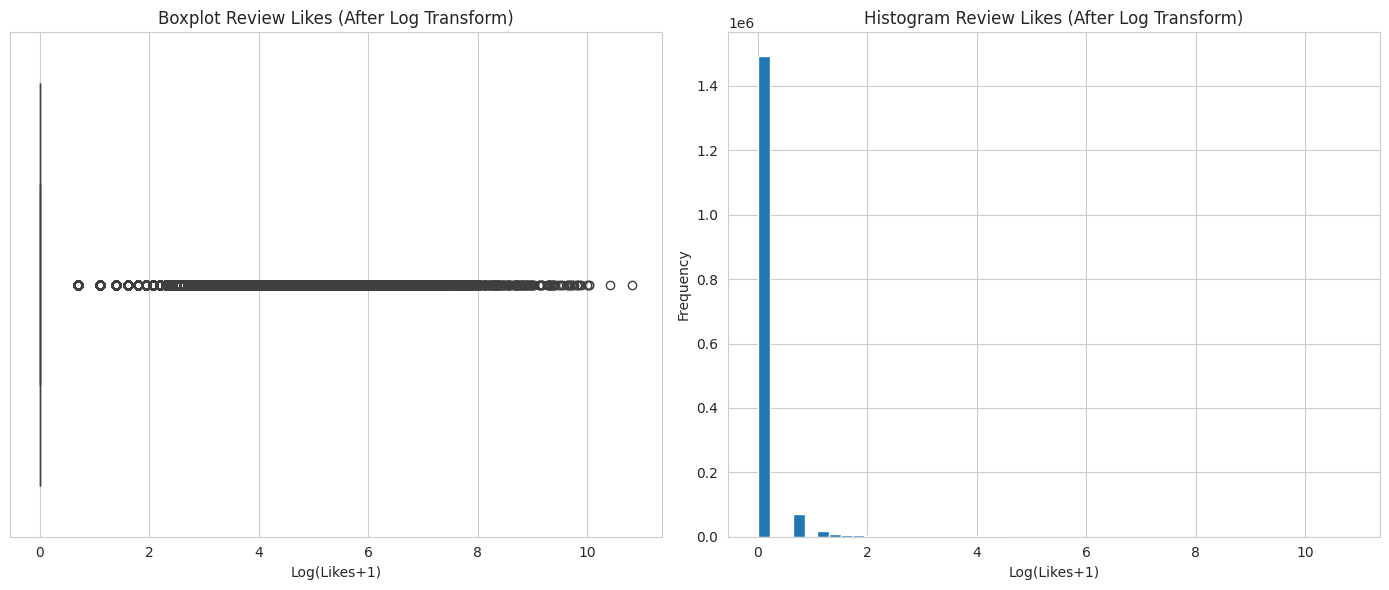

In [15]:
# Visualisasi Kolom review_likes dengan Boxplot dan Histogram Setelah Handling dg Log Transform 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

revlike_log_pandas = df.select('review_likes_log').toPandas() # Convert ke pandas

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot
sns.boxplot(x=revlike_log_pandas['review_likes_log'], vert=False, showfliers=True, ax=axes[0])
axes[0].set_title('Boxplot Review Likes (After Log Transform)')
axes[0].set_xlabel('Log(Likes+1)')

# Histogram
axes[1].hist(revlike_log_pandas['review_likes_log'], bins=50)
axes[1].set_title('Histogram Review Likes (After Log Transform)')
axes[1].set_xlabel('Log(Likes+1)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
# Normalisasi: Kolom review_likes menggunakan MinMaxScaler

from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Membuat kolom vector dari kolom review_likes_log
assembler = VectorAssembler(inputCols=['review_likes_log'], outputCol='review_likes_vector')
df_vector = assembler.transform(df)

# Normalisasi dengan MinMaxScaler
scaler = MinMaxScaler(inputCol='review_likes_vector', outputCol='review_likes_scaled')
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

# UDF untuk ekstrak vector ke float
extract_float = udf(lambda v: float(v[0]), FloatType())
df_final = df_scaled.withColumn('review_likes_scaled_float', extract_float('review_likes_scaled'))

# Hasil normalisasi 
df_final.select('review_likes_log', 'review_likes_scaled_float').show(5)
print('\033[1mKeterangan:\033[0m')
print('  - review_likes_log: kolom review_likes setelah handling outlier dengan log transform')
print('  - review_likes_scaled_float: kolom review_likes setelah handling outlier dan normalisasi')

[Stage 34:>                                                         (0 + 1) / 1]

+------------------+-------------------------+
|  review_likes_log|review_likes_scaled_float|
+------------------+-------------------------+
| 2.995732273553991|                0.2767119|
| 1.791759469228055|                0.1655025|
|2.1972245773362196|               0.20295478|
|               0.0|                      0.0|
|1.3862943611198906|               0.12805021|
+------------------+-------------------------+
only showing top 5 rows

Keterangan:
  - review_likes_log: kolom review_likes setelah handling outlier dengan log transform
  - review_likes_scaled_float: kolom review_likes setelah handling outlier dan normalisasi


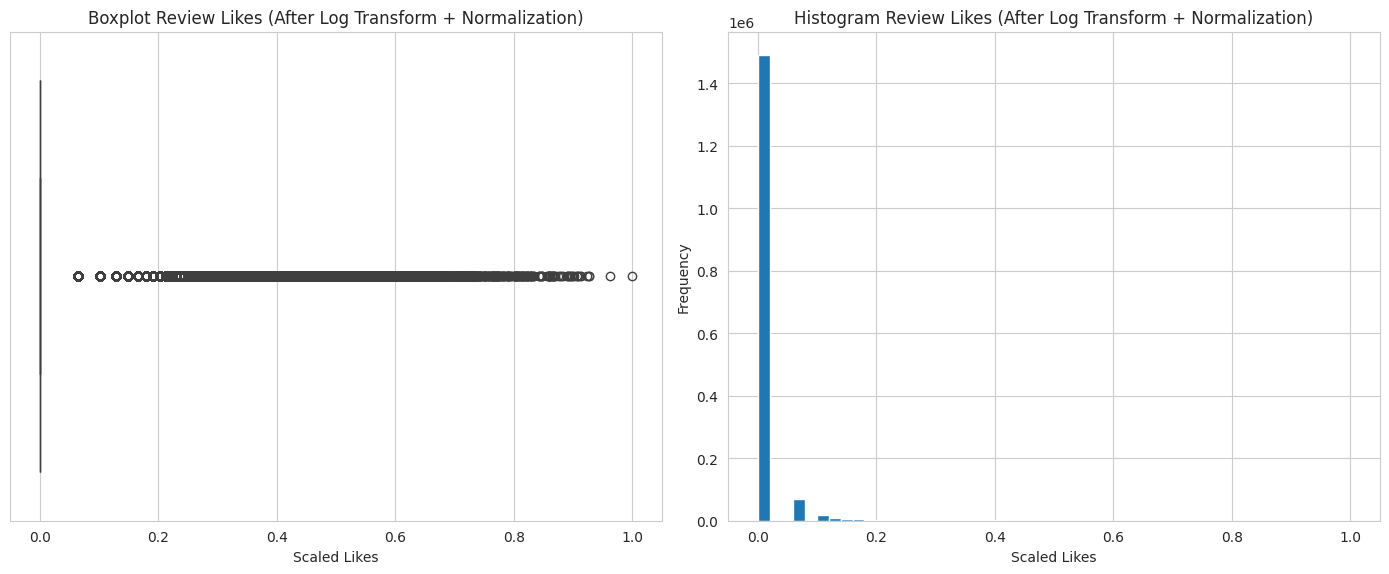

In [15]:
# Visualisasi Kolom review_likes dengan Boxplot dan Histogram Setelah Normalisasi

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

revlike_scaled_pandas = df_final.select('review_likes_scaled_float').toPandas() # Convert ke pandas

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot
sns.boxplot(x=revlike_scaled_pandas['review_likes_scaled_float'], vert=False, showfliers=True, ax=axes[0])
axes[0].set_title('Boxplot Review Likes (After Log Transform + Normalization)')
axes[0].set_xlabel('Scaled Likes')

# Histogram
axes[1].hist(revlike_scaled_pandas['review_likes_scaled_float'], bins=50)
axes[1].set_title('Histogram Review Likes (After Log Transform + Normalization)')
axes[1].set_xlabel('Scaled Likes')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [2]:
pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 537.2/537.2 kB 316.5 kB/s  0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_3740/173635720.py:37: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pd_topVersion['count'],
                                                                                

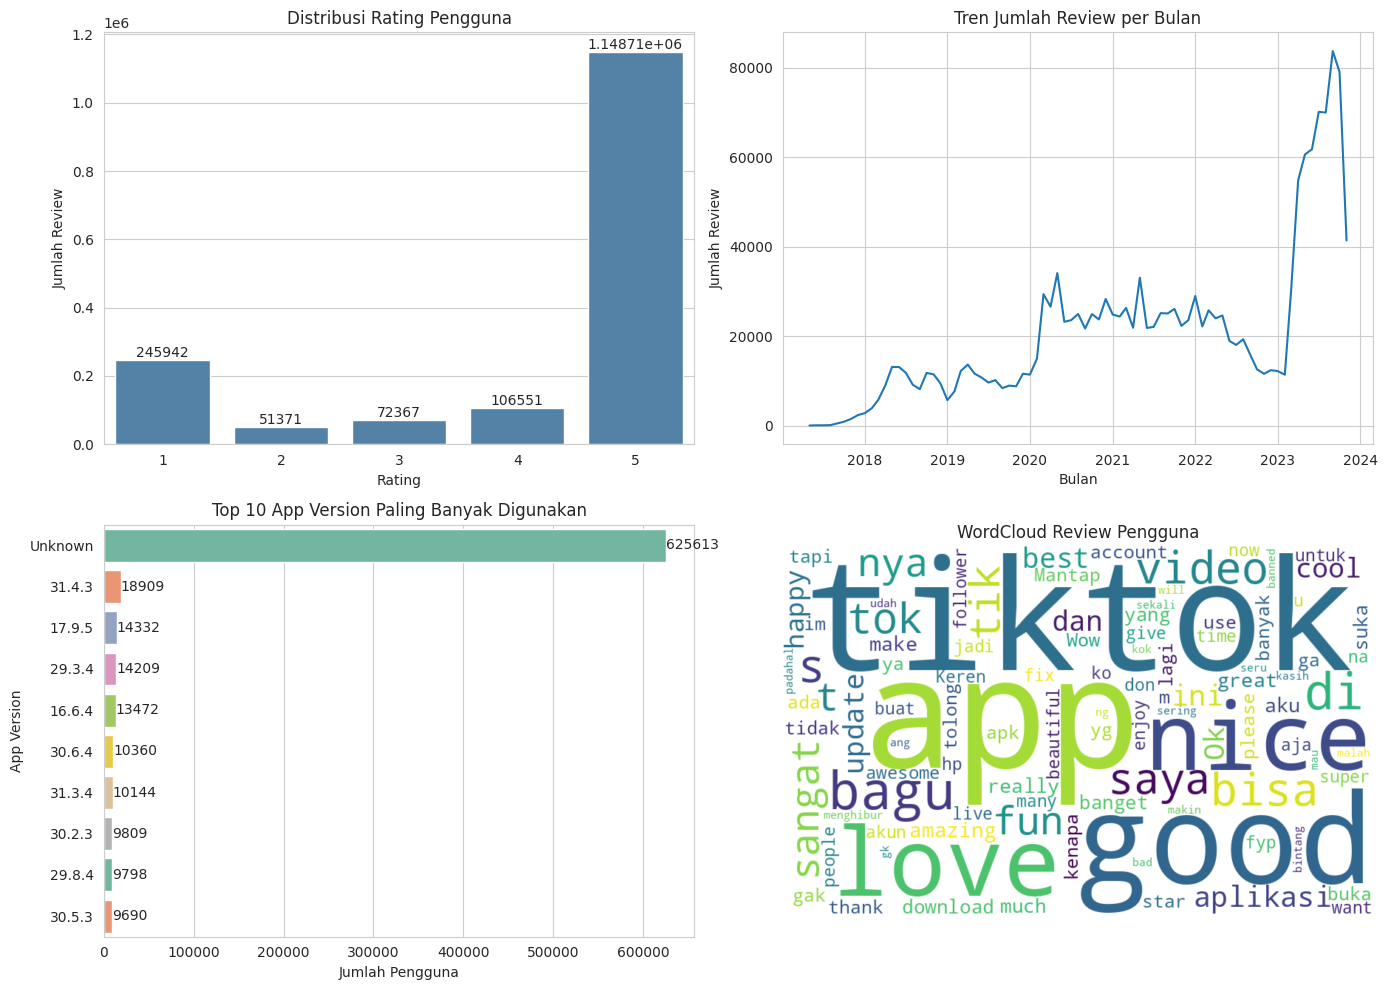

In [17]:
# Dashboard

from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Bar Chart - Disribusi Rating Penggunua
pd_rating = df_final.groupBy('review_rating').count().orderBy('review_rating').toPandas() # Convert ke Pandas
sns.barplot(x=pd_rating['review_rating'],
            y=pd_rating['count'],
            color='steelblue',
            ax=axes[0, 0])
axes[0, 0].set_title('Distribusi Rating Pengguna')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Jumlah Review')
# tambah label angka
for i in axes [0, 0].containers:
    axes[0, 0].bar_label(i)

# Plot - Tren Review per Bulan
df_final = df_final.withColumn('month', col('review_timestamp').substr(1,7)) #YYYY-MM
pd_monthly = df_final.groupBy('month').count().orderBy('month').toPandas() # Convert ke Pandas
pd_monthly['month'] = pd.to_datetime(pd_monthly['month'])
axes[0, 1].plot(pd_monthly['month'], pd_monthly['count'])
axes[0, 1].set_title('Tren Jumlah Review per Bulan')
axes[0, 1].set_xlabel('Bulan')
axes[0, 1].set_ylabel('Jumlah Review')

# Bar Chart - Top 10 Versi Aplikasi
pd_topVersion = df_final.groupBy('author_app_version').count().orderBy(col('count').desc()).limit(10).toPandas() # Convert ke Pandas
sns.barplot(x=pd_topVersion['count'], 
            y=pd_topVersion['author_app_version'], 
            palette='Set2', 
            ax=axes[1, 0])
axes[1, 0].set_title('Top 10 App Version Paling Banyak Digunakan')
axes[1, 0].set_xlabel('Jumlah Pengguna')
axes[1, 0].set_ylabel('App Version')
# tambah label angka
for i in axes [1, 0].containers:
    axes[1, 0].bar_label(i)

# Wordcloud dari Review Text
# ambil sampel 50.000 baris
pd_sample = df_final.select('review_text').sample(fraction=0.05, seed=42).toPandas() # Convert ke Pandas
# hapus karakter non-latin, menyisakan huruf alphabet dan spasi
pd_sample['clean_text'] = pd_sample['review_text'].apply(lambda x: re.sub(r'[^a-zA-Z]+', ' ', str(x)))
# setting WordCloud
all_text = ' '.join(pd_sample['clean_text'])
wordcloud = WordCloud(width=800, 
                      height=500, 
                      background_color='white',
                      colormap='viridis',
                      max_words=100, 
                      collocations=False).generate(all_text)
axes[1, 1].imshow(wordcloud, interpolation='bilinear')
axes[1, 1].axis('off')
axes[1, 1].set_title('WordCloud Review Pengguna')

# Menampilkan visualisasi
plt.tight_layout()
plt.show()

In [ ]:
# Machine Learning

In [12]:
# Tokenizer: memecah teks menjadi beberapa kata (token)

from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='review_text',
                      outputCol='tokens')

df_token = tokenizer.transform(df_final)
df_token.select('review_text', 'tokens').show(5)

+--------------+------------------+
|   review_text|            tokens|
+--------------+------------------+
|Cool video app|[cool, video, app]|
|          Cool|            [cool]|
|        fany！|          [fany！]|
|          COOL|            [cool]|
|        funny~|          [funny~]|
+--------------+------------------+
only showing top 5 rows



In [13]:
# StopWord Remover

from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol='tokens',
                           outputCol='filtered_tokens')

df_clean = remover.transform(df_token)
df_clean.select('tokens', 'filtered_tokens').show(5)

+------------------+------------------+
|            tokens|   filtered_tokens|
+------------------+------------------+
|[cool, video, app]|[cool, video, app]|
|            [cool]|            [cool]|
|          [fany！]|          [fany！]|
|            [cool]|            [cool]|
|          [funny~]|          [funny~]|
+------------------+------------------+
only showing top 5 rows



In [14]:
# TF-IDF

from pyspark.ml.feature import CountVectorizer, IDF

cv = CountVectorizer(inputCol='filtered_tokens',
                     outputCol='raw_features',
                     vocabSize=5000)

cv_model = cv.fit(df_clean)
df_cv = cv_model.transform(df_clean)

idf = IDF(inputCol='raw_features',
          outputCol='features')

idf_model = idf.fit(df_cv)
df_tfidf = idf_model.transform(df_cv)

df_tfidf.select('filtered_tokens', 'features').show(5)

+------------------+--------------------+
|   filtered_tokens|            features|
+------------------+--------------------+
|[cool, video, app]|(5000,[2,19,21],[...|
|            [cool]|(5000,[21],[4.019...|
|          [fany！]|        (5000,[],[])|
|            [cool]|(5000,[21],[4.019...|
|          [funny~]|        (5000,[],[])|
+------------------+--------------------+
only showing top 5 rows



In [15]:
# Encode Label
# Labeling Sentiment Menggunakan Kolom review_rating untuk Sentiment Classification

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType

# Fungsi untuk mengubah rating menjadi sentimen
def rating_to_sentiment(r):
    if r is None:
        return None
    if r <= 2: 
        return 'negative' # rating 1-2 = negatif
    elif r == 3: 
        return 'neutral'  # rating 3 = netral
    else:  
        return 'positive' # rating 4-5 = positif

# Register UDF untuk mendapatkan label string
rating_udf = udf(rating_to_sentiment, StringType())

# Membuat kolom 'sentiment'
df = df.withColumn('sentiment', rating_udf(col('review_rating')))

# Encode label sesuai urutan sentimen (0: negatif, 1: netral, 2: positif)
def sentiment_encode(s):
    if s == 'negative':
        return 0
    elif s == 'neutral':
        return 1
    elif s == 'positive':
        return 2
    else:
        return None

encode_udf = udf(sentiment_encode, IntegerType())

# Membuat kolom 'label'
df = df.withColumn('label', encode_udf(df['sentiment']))

# Hasil encoding
print('Labeling Sentiment berhasil dibuat!')
df.select('review_rating', 'sentiment', 'label').show(10)

Labeling Sentiment berhasil dibuat!
+-------------+---------+-----+
|review_rating|sentiment|label|
+-------------+---------+-----+
|            5| positive|    2|
|            5| positive|    2|
|            5| positive|    2|
|            5| positive|    2|
|            5| positive|    2|
|            5| positive|    2|
|            4| positive|    2|
|            2| negative|    0|
|            4| positive|    2|
|            3|  neutral|    1|
+-------------+---------+-----+
only showing top 10 rows



In [16]:
# Pipeline

from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

tokenizer = Tokenizer(inputCol='review_text', outputCol='text_token')
remover = StopWordsRemover(inputCol='text_token', outputCol='clean_token')
hashingTF = HashingTF(inputCol='clean_token', outputCol='raw_features', numFeatures=1 << 10)
idf = IDF(inputCol='raw_features', outputCol='features')

preprocess_pipeline = Pipeline(stages=[
    tokenizer,
    remover,
    hashingTF,
    idf
])

# fit n transform dataset
preprocess_model = preprocess_pipeline.fit(df)
df_preprocessed = preprocess_model.transform(df)

df_preprocessed.select('review_text', 'features').show(10)

+---------------------------------+--------------------+
|                      review_text|            features|
+---------------------------------+--------------------+
|                   Cool video app|(1024,[387,565,99...|
|                             Cool|(1024,[387],[3.90...|
|                           fany！|(1024,[694],[5.99...|
|                             COOL|(1024,[387],[3.90...|
|                           funny~|(1024,[350],[5.87...|
|                            Funny|(1024,[658],[4.69...|
|                             Good|(1024,[792],[2.24...|
|             erm I rather use ...|(1024,[95,105,145...|
|                         not bad.|(1024,[79],[6.096...|
|是不错的app 但是为什么我想用面...|(1024,[50,86,833]...|
+---------------------------------+--------------------+
only showing top 10 rows



In [17]:
# Train-Test Split
# Memisahkan data untuk pelatihan dan pengujian

train, test = df_preprocessed.randomSplit([0.8, 0.2], seed=42)

print('Proses Train-Test Split berhasil dilakukan!')
print('Train:', train.count())
print('Test :', test.count())

Proses Train-Test Split berhasil dilakukan!


Train: 1299926


Test : 325019


In [18]:
# Machine Learning - Logistic Regression

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='label')

print('Training model Logistic Regression ...')
lr_model = lr.fit(train)
lr_pred = lr_model.transform(test)

print('Model Logistic Regression berhasil dilatih!')

Training model Logistic Regression ...


25/11/26 07:59:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
                                                                                

Model Logistic Regression berhasil dilatih!


In [19]:
# Machine Learning - Naive Bayes

from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol='features', labelCol='label', modelType='multinomial')

print('Training model Naive Bayes ...')
nb_model = nb.fit(train)
nb_pred = nb_model.transform(test)

print('Model Naive Bayes berhasil dilatih!')

Training model Naive Bayes ...


Model Naive Bayes berhasil dilatih!


In [20]:
# Machine Learning - Evaluasi Model Logistic Regression dan Naive Bayes

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr_pred = lr_model.transform(test) # Prediksi LR
nb_pred = nb_model.transform(test) # Prediksi NB

# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')

lr_acc = evaluator.evaluate(lr_pred, {evaluator.metricName: 'accuracy'})
lr_f1 = evaluator.evaluate(lr_pred, {evaluator.metricName: 'f1'})

nb_acc = evaluator.evaluate(nb_pred, {evaluator.metricName: 'accuracy'})
nb_f1 = evaluator.evaluate(nb_pred, {evaluator.metricName: 'f1'})

print('\033[1m=== EVALUASI MODEL LOGISTIC REGRESSION ===\033[0m')
print('Akurasi :', lr_acc)
print('F1-Score:', lr_f1)
print('\033[1m======= EVALUASI MODEL NAIVE BAYES =======\033[0m')
print('Akurasi :', nb_acc)
print('F1-Score:', nb_f1)

[Stage 109:============================>                            (2 + 2) / 4]

=== EVALUASI MODEL LOGISTIC REGRESSION ===
Akurasi : 0.8127647922121476
F1-Score: 0.7730982363871215
======= EVALUASI MODEL NAIVE BAYES =======
Akurasi : 0.7434273073266486
F1-Score: 0.7520831510304427


In [24]:
# Confusion Matrix

from pyspark.sql.functions import col

print('\033[1m=== CONFUSION MATRIX: LOGISTIC REGRESSION ===\033[0m')
lr_pred.groupBy('label', 'prediction').count().show()
print('\033[1m======= CONFUSION MATRIX: NAIVE BAYES =======\033[0m')
nb_pred.groupBy('label', 'prediction').count().show()

=== CONFUSION MATRIX: LOGISTIC REGRESSION ===


25/11/26 06:29:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:03 WARN RowBasedKeyValueBatch: Calling spill() on

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    2|       1.0|   244|
|    1|       0.0|  3001|
|    0|       2.0| 39834|
|    0|       0.0| 19369|
|    1|       2.0| 11312|
|    2|       2.0|244453|
|    1|       1.0|   342|
|    2|       0.0|  6213|
|    0|       1.0|   251|
+-----+----------+------+

======= CONFUSION MATRIX: NAIVE BAYES =======


25/11/26 06:29:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 06:29:30 WARN RowBasedKeyValueBatch: Calling spill() on

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    2|       1.0|  9891|
|    1|       0.0|  4529|
|    0|       2.0| 23312|
|    0|       0.0| 29552|
|    1|       2.0|  7304|
|    2|       2.0|209254|
|    1|       1.0|  2822|
|    2|       0.0| 31765|
|    0|       1.0|  6590|
+-----+----------+------+



25/11/26 08:07:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 08:07:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 08:07:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 08:07:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 08:07:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 08:07:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 08:07:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 08:07:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/11/26 08:07:27 WARN RowBasedKeyValueBatch: Calling spill() on

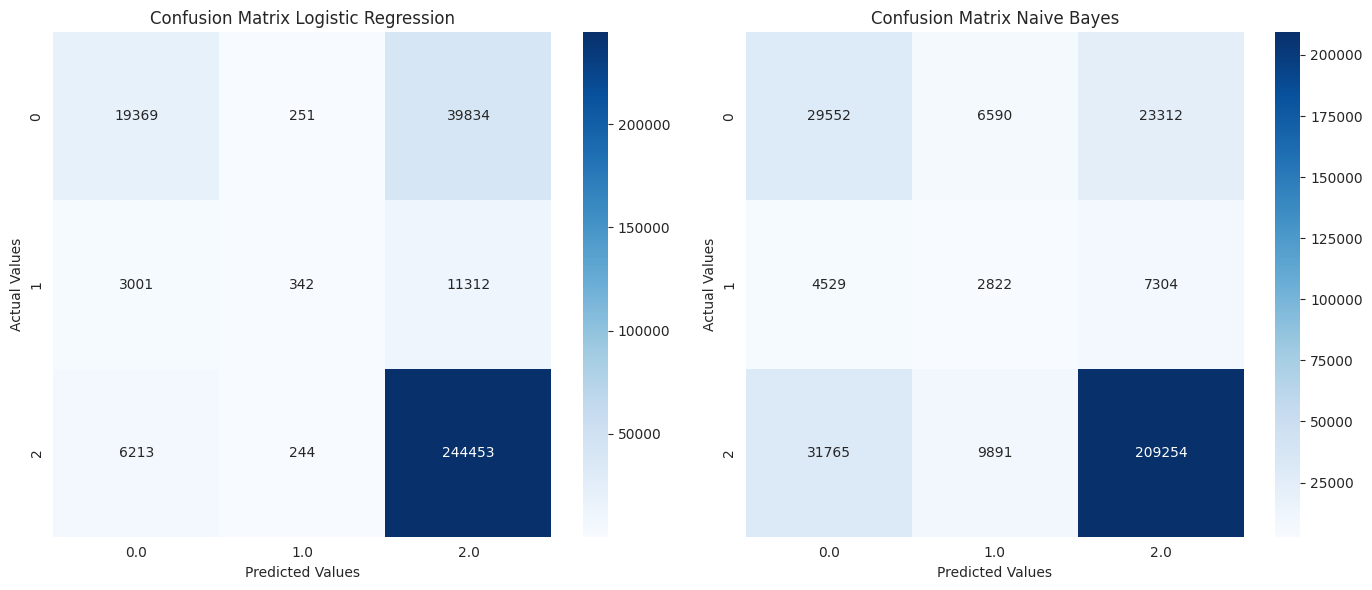

In [22]:
# Visualisasi Confusion Matrix

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil confusion matrix dari Spark, lalu convert ke Pandas
cm_lr = lr_pred.groupBy('label', 'prediction').count().toPandas()
cm_nb = nb_pred.groupBy('label', 'prediction').count().toPandas()

# Pivot table untuk membentuk matrix
matrix_lr = cm_lr.pivot(index='label', columns='prediction', values='count').fillna(0)
matrix_nb = cm_nb.pivot(index='label', columns='prediction', values='count').fillna(0)

# Styling plot
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Logistic Regression
sns.heatmap(matrix_lr, 
            annot=True, 
            fmt='.0f', 
            cmap='Blues', 
            ax=axes[0])
axes[0].set_title('Confusion Matrix Logistic Regression')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Actual Values')

# Naive Bayes
sns.heatmap(matrix_nb, 
            annot=True, 
            fmt='.0f', 
            cmap='Blues', 
            ax=axes[1])
axes[1].set_title('Confusion Matrix Naive Bayes')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Actual Values')

# Final styling
plt.tight_layout()
plt.show()